In [189]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from lightgbm import LGBMRegressor

# Import Data

In [8]:
df = pd.read_csv("combined_df.csv")
df = df[
    (df['Year'] >= 2020) &
    (~(df['Headliner'].str.contains('"', na=False))) & 
    (df['Genre'] != 'Family Entertainment') &
    (df['Ticket Price Min USD'] > 0) &
    (df['Ticket Price Min USD'] < df['Ticket Price Max USD'])
]
df = df.dropna()
df['Event Date'] = pd.to_datetime(df['Event Date'], errors='coerce')
# Reset index after dropping rows
df = df.reset_index(drop=True)
df

/var/folders/5p/g82q05js0bs2xkv11dw5ksy80000gn/T/ipykernel_96516/1824778265.py:1: DtypeWarning: Columns (2,3,6,7,8,9,10,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("combined_df.csv")


,Event Date,Headliner,sp artist_name,sp artist_genre,sp followers,sp popularity,yt name,yt Channel ID,yt Title,yt Description,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,Month,day_of_week
0,2024-09-18,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,20295.0,1228939.0,20295.0,100%,39.5,225.0,60.55,9,2
1,2024-09-14,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,16308.0,1374174.0,16308.0,100%,39.5,225.0,84.26,9,5
2,2024-09-13,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,14995.0,1402969.0,14995.0,100%,39.5,225.0,93.56,9,4
3,2024-09-11,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,19303.0,1512310.0,19303.0,100%,39.5,159.5,78.35,9,2
4,2024-09-10,Creed,Creed,"['alternative metal', 'nu metal', 'post-grunge...",3527070.0,74.0,Creed,UCP-tFf_VMQzhyeKMONL1KvQ,Creed,Subscribe to Creed's Official Youtube Channel ...,...,Pop / Rock,10945.0,801952.0,10945.0,100%,39.5,159.5,73.27,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,2020-01-16,Ider,Ider,[],5.0,0.0,Ider,UCv8KgX89OA0yyPVAgoxx5lw,IDER,'Late To The World' OUT NOW! \n\nThe title tra...,...,Pop / Rock,227.0,3282.0,250.0,90%,15.0,100.0,14.46,1,3
3357,2020-01-16,Green Jelly,Green Jelly,"['comic metal', 'funk metal']",60041.0,35.0,Green Jelly,UCW8soHbDw-sZ8X2Cjb-2VcA,Green Jellÿ,Official Channel of Green Jello / Green Jelly\...,...,Pop / Rock,117.0,1260.0,200.0,58%,10.0,12.0,10.77,1,3
3358,2020-01-15,Grace Potter,Grace Potter,[],126207.0,55.0,Grace Potter,UChZPBtiR55itE778bGV3PlQ,Grace Potter,New album “Mother Road” out now: https://found...,...,Pop / Rock,852.0,36679.0,1868.0,45%,38.5,48.5,43.05,1,2
3359,2020-01-15,Caroline Polachek,Caroline Polachek,"['art pop', 'escape room', 'indie pop', 'indie...",542299.0,62.0,Caroline Polachek,UC_YiGpMGuBb1PbjqPQMf9MQ,Caroline Polachek,The official YouTube channel of Caroline Polachek,...,Pop / Rock,500.0,9250.0,500.0,100%,20.0,100.0,18.50,1,2


# Data Preprocessing

In [11]:
# Remove the after-concert data
columns_to_exclude = ['Avg. Tickets Sold', 'Avg. Capacity Sold', 'Ticket Price Avg. USD']
df = df.drop(columns=columns_to_exclude, errors='ignore')

# Extract time features from dates
df['Year'] = df['Event Date'].dt.year
df['Month'] = df['Event Date'].dt.month
df['Day'] = df['Event Date'].dt.day
df['Day_of_Week'] = df['Event Date'].dt.dayofweek
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3361 entries, 0 to 3360
Data columns (total 53 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Event Date                       3361 non-null   datetime64[ns]
 1   Headliner                        3361 non-null   object        
 2   sp artist_name                   3361 non-null   object        
 3   sp artist_genre                  3361 non-null   object        
 4   sp followers                     3361 non-null   float64       
 5   sp popularity                    3361 non-null   float64       
 6   yt name                          3361 non-null   object        
 7   yt Channel ID                    3361 non-null   object        
 8   yt Title                         3361 non-null   object        
 9   yt Description                   3361 non-null   object        
 10  yt Published At                  3361 non-null   object     

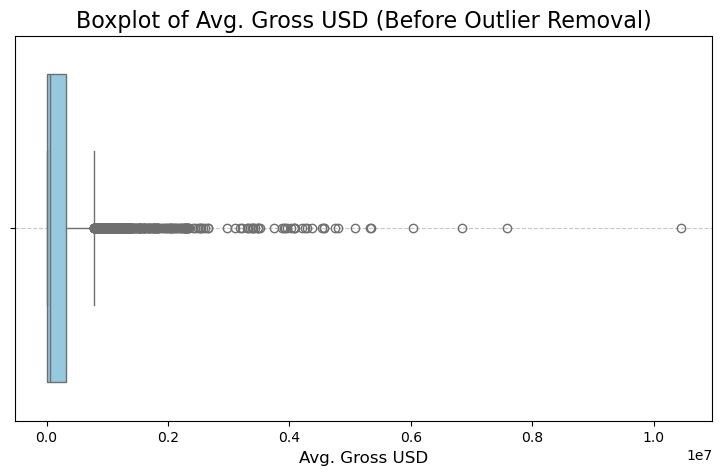

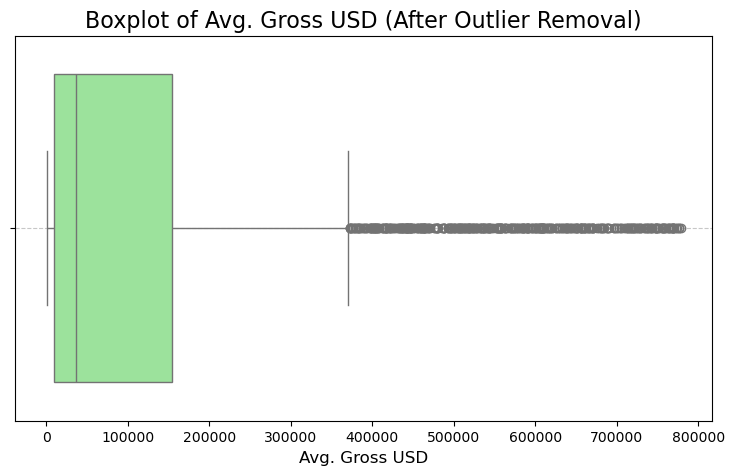

In [13]:
# Boxplot (before excluding outliers)
plt.figure(figsize=(9, 5))
sns.boxplot(x=df['Avg. Gross USD'], color='skyblue')
plt.title("Boxplot of Avg. Gross USD (Before Outlier Removal)", fontsize=16)
plt.xlabel("Avg. Gross USD", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calculate the IQR and remove the outliers
q1 = df['Avg. Gross USD'].quantile(0.25)
q3 = df['Avg. Gross USD'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df_filtered = df[(df['Avg. Gross USD'] >= lower_bound) & (df['Avg. Gross USD'] <= upper_bound)]

# Boxplot (after excluding outliers)
plt.figure(figsize=(9, 5))
sns.boxplot(x=df_filtered['Avg. Gross USD'], color='lightgreen')
plt.title("Boxplot of Avg. Gross USD (After Outlier Removal)", fontsize=16)
plt.xlabel("Avg. Gross USD", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Exploratory Data Analysis

In [16]:
# Check statistic analysis for Avg. Gross USD
print("Descriptive Statistics for Avg. Gross USD:")
print(df['Avg. Gross USD'].describe())

# Filters numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation between numerical features and target variables
correlations = df[numeric_columns].corr()['Avg. Gross USD'].sort_values(ascending=False)
print("\nCorrelation of numerical features with Avg. Gross USD:")
print(correlations)

Descriptive Statistics for Avg. Gross USD:
count    3.361000e+03
mean     3.036503e+05
std      6.307795e+05
min      1.900000e+02
25%      1.075500e+04
50%      5.149550e+04
75%      3.179813e+05
max      1.044296e+07
Name: Avg. Gross USD, dtype: float64

Correlation of numerical features with Avg. Gross USD:
Avg. Gross USD                     1.000000
Avg. Event Capacity                0.816177
Ticket Price Max USD               0.584927
sp followers                       0.533951
monthly_listeners                  0.522213
headliner_monthly_listeners        0.522213
sp popularity                      0.456942
yt View Count                      0.427038
Ticket Price Min USD               0.412459
yt Subscriber Count                0.357633
yt Video Count                     0.094437
Number of Shows                    0.068983
10 to 14 years population          0.060112
5 to 9 years population            0.057795
55 to 59 years population          0.056746
15 to 19 years population   

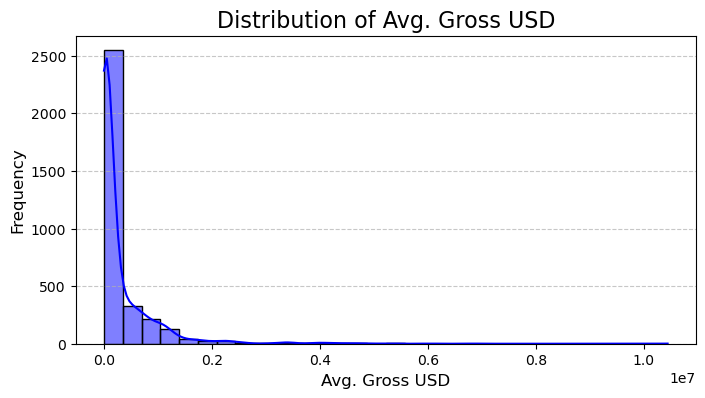

In [18]:
# Target variable distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['Avg. Gross USD'], bins=30, kde=True, color='blue')
plt.title("Distribution of Avg. Gross USD", fontsize=16)
plt.xlabel("Avg. Gross USD", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

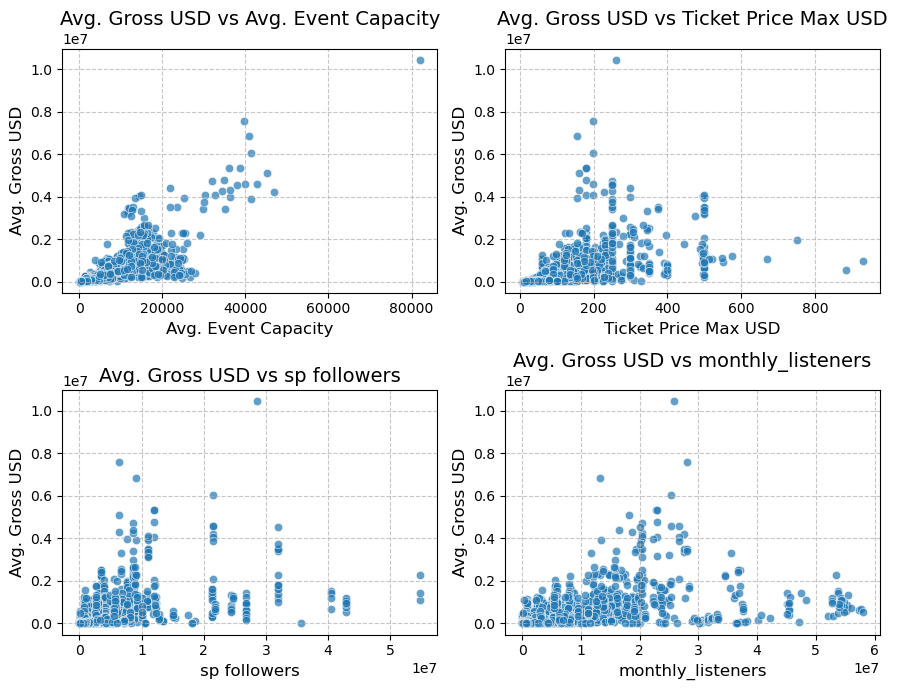

In [20]:
# Top 4 high scores feature related with Avg. Gross USD
features_to_plot = ['Avg. Event Capacity', 'Ticket Price Max USD', 'sp followers', 'monthly_listeners']

fig, axes = plt.subplots(2, 2, figsize=(9, 7))
axes = axes.flatten()

for i, feature in enumerate(features_to_plot):
    sns.scatterplot(x=df[feature], y=df['Avg. Gross USD'], alpha=0.7, ax=axes[i])
    axes[i].set_title(f"Avg. Gross USD vs {feature}", fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel("Avg. Gross USD", fontsize=12)
    axes[i].grid(axis='both', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [22]:
# Check the types of genres
print("Unique genres in the dataset:")
print(df['Genre'].unique()) # got only one type

print("\nDistribution of genres:")
print(df['Genre'].value_counts())
# Decrease data redundancy and model complexity
df = df.drop(columns=['Genre'], errors='ignore')

Unique genres in the dataset:
['Pop / Rock']

Distribution of genres:
Genre
Pop / Rock    3361
Name: count, dtype: int64


/var/folders/5p/g82q05js0bs2xkv11dw5ksy80000gn/T/ipykernel_96516/3293075121.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df[df['City'].isin(top_cities)], x='City', y='Avg. Gross USD', order=sorted_cities, palette='Set3')


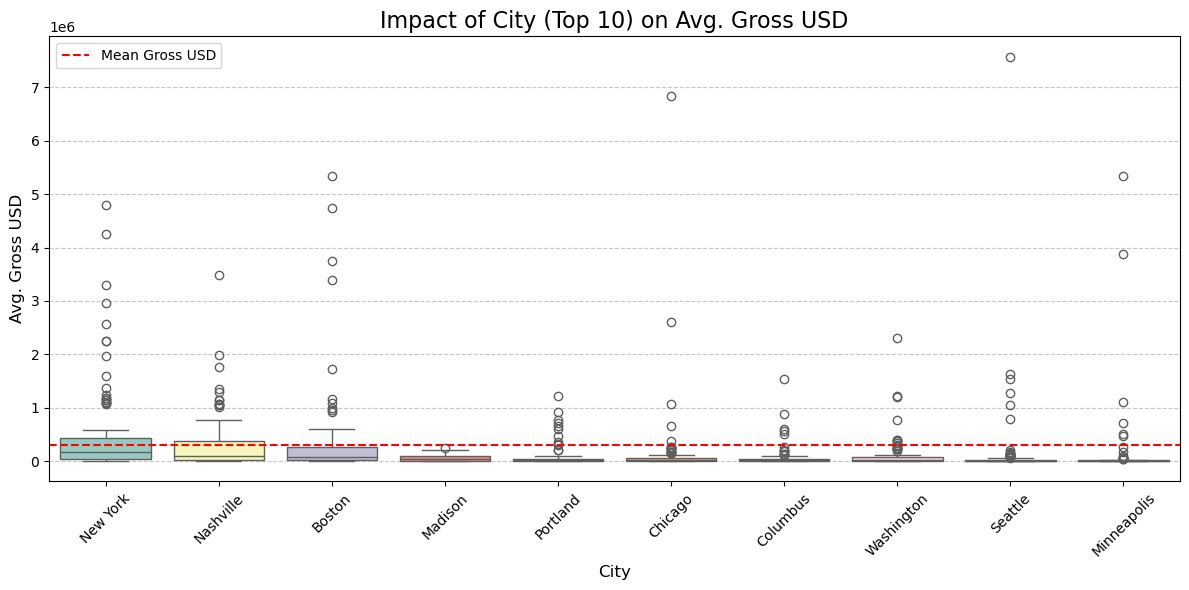

In [24]:
# Impact of City on Avg. Gross USD (Ranked by Median)
top_cities = df['City'].value_counts().head(10).index
median_gross = df[df['City'].isin(top_cities)].groupby('City')['Avg. Gross USD'].median().sort_values(ascending=False)
sorted_cities = median_gross.index
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['City'].isin(top_cities)], x='City', y='Avg. Gross USD', order=sorted_cities, palette='Set3')

# Add a reference line
mean_gross = df['Avg. Gross USD'].mean()
plt.axhline(mean_gross, color='red', linestyle='--', linewidth=1.5, label='Mean Gross USD')

plt.title("Impact of City (Top 10) on Avg. Gross USD", fontsize=16)
plt.xlabel("City", fontsize=12)
plt.ylabel("Avg. Gross USD", fontsize=12)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Feature Engineering

In [27]:
# Extraction time feature
df['Year'] = df['Event Date'].dt.year
df['Month'] = df['Event Date'].dt.month
df['Day'] = df['Event Date'].dt.day
df['Day_of_Week'] = df['Event Date'].dt.dayofweek
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

print(df[['Event Date', 'Year', 'Month', 'Day', 'Day_of_Week', 'Is_Weekend']].head())

  Event Date  Year  Month  Day  Day_of_Week  Is_Weekend
0 2024-09-18  2024      9   18            2           0
1 2024-09-14  2024      9   14            5           1
2 2024-09-13  2024      9   13            4           0
3 2024-09-11  2024      9   11            2           0
4 2024-09-10  2024      9   10            1           0


In [29]:
# Initializes the target encoder
target_encoder = TargetEncoder()

# Target code the City column
df['City_encoded'] = target_encoder.fit_transform(df['City'], df['Avg. Gross USD'])
print(df[['City', 'City_encoded']].head())

            City   City_encoded
0        Raleigh  372286.315796
1  The Woodlands  498265.755355
2    San Antonio  392506.247703
3         Dallas  369553.384283
4         Rogers  359601.979344


In [31]:
# Generated interaction feature
df['Capacity_Ticket_Interaction'] = df['Avg. Event Capacity'] * df['Ticket Price Max USD']

print(df[['Avg. Event Capacity', 'Ticket Price Max USD', 'Capacity_Ticket_Interaction']].head())

   Avg. Event Capacity  Ticket Price Max USD  Capacity_Ticket_Interaction
0              20295.0                 225.0                    4566375.0
1              16308.0                 225.0                    3669300.0
2              14995.0                 225.0                    3373875.0
3              19303.0                 159.5                    3078828.5
4              10945.0                 159.5                    1745727.5


In [33]:
# Calculate city-level statistical features
city_stats = df.groupby('City')['Avg. Gross USD'].agg(['mean', 'median']).reset_index()
city_stats.rename(columns={'mean': 'City_Avg_Gross_Mean', 'median': 'City_Avg_Gross_Median'}, inplace=True)

# Merge statistical features into original data
df = df.merge(city_stats, on='City', how='left')

print(df[['City', 'City_Avg_Gross_Mean', 'City_Avg_Gross_Median']].head())

            City  City_Avg_Gross_Mean  City_Avg_Gross_Median
0        Raleigh        464935.294118             404537.000
1  The Woodlands        890173.226923             948704.000
2    San Antonio        590258.875000              30310.125
3         Dallas        389403.022500              80448.000
4         Rogers        511694.509000             550708.000


In [35]:
# Filter numrical columns (correlation analysis)
numeric_columns = df.select_dtypes(include=['float64', 'int64'])
correlation_with_target = numeric_columns.corr()['Avg. Gross USD'].sort_values(ascending=False)

# Sort correlation
print("\nCorrelation with Avg. Gross USD:")
print(correlation_with_target)

# Filter features by relevance (threshold: 0.1)
selected_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()
df_selected = df[selected_features]

print("\nSelected Features:")
print(df_selected.head())


Correlation with Avg. Gross USD:
Avg. Gross USD                     1.000000
Avg. Event Capacity                0.816177
Capacity_Ticket_Interaction        0.771636
Ticket Price Max USD               0.584927
City_Avg_Gross_Mean                0.569458
sp followers                       0.533951
City_Avg_Gross_Median              0.526788
headliner_monthly_listeners        0.522213
monthly_listeners                  0.522213
sp popularity                      0.456942
City_encoded                       0.435316
yt View Count                      0.427038
Ticket Price Min USD               0.412459
yt Subscriber Count                0.357633
yt Video Count                     0.094437
Number of Shows                    0.068983
10 to 14 years population          0.060112
5 to 9 years population            0.057795
55 to 59 years population          0.056746
15 to 19 years population          0.056139
45 to 54 years population          0.055123
Under 5 years population           0.05442

In [37]:
# Filter features based on correlation (threshold: 0.5)
selected_features = correlation_with_target[correlation_with_target > 0.5].index.tolist()

# Remove non-used feature
selected_features = [feature for feature in selected_features if feature != 'Support_Total_Monthly_Listeners']

# Filtered data set
df_selected = df[selected_features]

print("\nSelected Features for Modeling:")
print(list(df_selected))


Selected Features for Modeling:
['Avg. Gross USD', 'Avg. Event Capacity', 'Capacity_Ticket_Interaction', 'Ticket Price Max USD', 'City_Avg_Gross_Mean', 'sp followers', 'City_Avg_Gross_Median', 'headliner_monthly_listeners', 'monthly_listeners']


# Training Models

In [40]:
# Define features and target variable
X = df[['Avg. Event Capacity', 'Capacity_Ticket_Interaction', 'Ticket Price Max USD', 
        'City_Avg_Gross_Mean', 'sp followers', 'City_Avg_Gross_Median', 
        'headliner_monthly_listeners', 'monthly_listeners']]
y = df['Avg. Gross USD']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Training set size: (2688, 8), Test set size: (673, 8)


### Linear Regression

In [43]:
# Linear Regression (3 types)
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=1.0, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0, random_state=42)
}

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

results = {}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    # CV MAE
    mae_scores = -cross_val_score(pipeline, X, y, cv=5, scoring=mae_scorer)
    avg_mae = np.mean(mae_scores)
    # CV MSE -> RMSE
    mse_scores = -cross_val_score(pipeline, X, y, cv=5, scoring=mse_scorer)
    rmse_scores = np.sqrt(mse_scores)
    avg_rmse = np.mean(rmse_scores)
    # CV R²
    r2_scores = cross_val_score(pipeline, X, y, cv=5, scoring=r2_scorer)
    avg_r2 = np.mean(r2_scores)
    
    print(f"  Average MAE: {avg_mae:.2f}")
    print(f"  Average RMSE: {avg_rmse:.2f}")
    print(f"  Average R^2: {avg_r2:.2f}")
    print("-" * 30)
    results[model_name] = {"MAE": avg_mae, "RMSE": avg_rmse, "R^2": avg_r2}

print("\nSummary of Cross-Valibdation Results:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.2f}")

Evaluating Linear Regression...
  Average MAE: 167139.77
  Average RMSE: 350956.45
  Average R^2: 0.64
------------------------------
Evaluating Lasso Regression...
  Average MAE: 166352.97
  Average RMSE: 349424.35
  Average R^2: 0.65
------------------------------
Evaluating Ridge Regression...
  Average MAE: 166230.05
  Average RMSE: 349402.21
  Average R^2: 0.65
------------------------------

Summary of Cross-Valibdation Results:
Linear Regression:
  MAE: 167139.77
  RMSE: 350956.45
  R^2: 0.64
Lasso Regression:
  MAE: 166352.97
  RMSE: 349424.35
  R^2: 0.65
Ridge Regression:
  MAE: 166230.05
  RMSE: 349402.21
  R^2: 0.65


### Random Forest

In [46]:
# Random Forest (without tune hyperparameter)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# CV MAE
mae_scores = -cross_val_score(rf_model, X, y, cv=5, scoring=mae_scorer)
avg_mae = np.mean(mae_scores)

# CV MSE -> RMSE
mse_scores = -cross_val_score(rf_model, X, y, cv=5, scoring=mse_scorer)
rmse_scores = np.sqrt(mse_scores)
avg_rmse = np.mean(rmse_scores)

# CV R²
r2_scores = cross_val_score(rf_model, X, y, cv=5, scoring=r2_scorer)
avg_r2 = np.mean(r2_scores)

print("Random Forest Cross-Validation Results:")
print(f"  Average MAE: {avg_mae:.2f}")
print(f"  Average RMSE: {avg_rmse:.2f}")
print(f"  Average R^2: {avg_r2:.2f}")

Random Forest Cross-Validation Results:
  Average MAE: 105794.72
  Average RMSE: 288528.90
  Average R^2: 0.73


In [48]:
# Random Forest (tune hyperparameter)
param_distributions = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42)

# Random Search (In a large space)
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_distributions,
    n_iter=40,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Random Search Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Random Search Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}


In [50]:
# Use GridSearchCV for a more refined search
param_grid = {
    'n_estimators': [450, 500, 550],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': [None, 'sqrt']
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Grid Search Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Grid Search Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}


In [52]:
# Initialize the final model with the best parameters
final_rf_model = RandomForestRegressor(
    max_depth=None,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=500,
    random_state=42
)

final_rf_model.fit(X_train, y_train)

RandomForestRegressor(max_features=None, min_samples_split=3, n_estimators=500,
                      random_state=42)

In [54]:
# Evaluates model performance using cross-validation on the training set
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# CV MAE
mae_scores = -cross_val_score(final_rf_model, X_train, y_train, cv=5, scoring=mae_scorer)
avg_mae = np.mean(mae_scores)

# CV MSE -> RMSE
mse_scores = -cross_val_score(final_rf_model, X_train, y_train, cv=5, scoring=mse_scorer)
rmse_scores = np.sqrt(mse_scores)
avg_rmse = np.mean(rmse_scores)

# CV R²
r2_scores = cross_val_score(final_rf_model, X_train, y_train, cv=5, scoring=r2_scorer)
avg_r2 = np.mean(r2_scores)

print("Cross-Validation Results (Training Set):")
print(f"  Average MAE: {avg_mae:.2f}")
print(f"  Average RMSE: {avg_rmse:.2f}")
print(f"  Average R^2: {avg_r2:.2f}")

Cross-Validation Results (Training Set):
  Average MAE: 73449.21
  Average RMSE: 209029.46
  Average R^2: 0.89


In [55]:
# Evaluates final performance on test set

y_test_pred = final_rf_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Results:")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  R^2: {test_r2:.2f}")

Test Set Results:
  MAE: 70313.34
  RMSE: 175464.26
  R^2: 0.91


In [58]:
# Find feature importance of final_rf model

feature_importances = final_rf_model.feature_importances_
for name, importance in zip(X_train.columns, feature_importances):
    print(f"{name}: {importance:.4f}")

Avg. Event Capacity: 0.3816
Capacity_Ticket_Interaction: 0.4603
Ticket Price Max USD: 0.0354
City_Avg_Gross_Mean: 0.0201
sp followers: 0.0462
City_Avg_Gross_Median: 0.0170
headliner_monthly_listeners: 0.0203
monthly_listeners: 0.0192


### XGBoost

In [61]:
# XGBoost (without tune hyperparameter)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# CV MAE
mae_scores = -cross_val_score(xgb_model, X, y, cv=5, scoring=mae_scorer)
avg_mae = np.mean(mae_scores)

# CV MSE -> RMSE
mse_scores = -cross_val_score(xgb_model, X, y, cv=5, scoring=mse_scorer)
rmse_scores = np.sqrt(mse_scores)
avg_rmse = np.mean(rmse_scores)

# CV R²
r2_scores = cross_val_score(xgb_model, X, y, cv=5, scoring=r2_scorer)
avg_r2 = np.mean(r2_scores)

print("XGBoost Cross-Validation Results:")
print(f"  Average MAE: {avg_mae:.2f}")
print(f"  Average RMSE: {avg_rmse:.2f}")
print(f"  Average R^2: {avg_r2:.2f}")

XGBoost Cross-Validation Results:
  Average MAE: 99391.23
  Average RMSE: 265969.34
  Average R^2: 0.78


In [63]:
# XGBoost (tune hyperparameter)

param_distributions = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 10, 15],
    'min_child_weight': [1, 2, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 3]
}

xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

# Random Search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Random Search Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Search Best Parameters: {'subsample': 0.6, 'reg_lambda': 3, 'reg_alpha': 1, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}


In [65]:
# Use GridSearchCV for a more refined search
param_grid = {
    'learning_rate': [0.08, 0.1, 0.12],
    'max_depth': [4, 5, 6], 
    'n_estimators': [450, 500, 550],
    'subsample': [0.6],
    'colsample_bytree': [1.0],
    'min_child_weight': [1],
    'gamma': [0.4, 0.5, 0.6],
    'reg_alpha': [0.5, 1, 1.5],
    'reg_lambda': [2.5, 3, 3.5]
}

#  Grid Search CV
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, objective='reg:squarederror'),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    # verbose=2,
    verbose=0,  # Set verbose to 0 to suppress detailed output
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Grid Search Best Parameters:", grid_search.best_params_)

Grid Search Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.4, 'learning_rate': 0.12, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 550, 'reg_alpha': 0.5, 'reg_lambda': 2.5, 'subsample': 0.6}


In [67]:
# Initialize the XGBoost model with the best parameters
final_xgb_model = XGBRegressor(
    colsample_bytree=1.0,
    gamma=0.4,
    learning_rate=0.12,
    max_depth=4,
    min_child_weight=1,
    n_estimators=550,
    reg_alpha=0.5,
    reg_lambda=2.5,
    subsample=0.6,
    random_state=42,
    objective='reg:squarederror'
)

final_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.4, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.12, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=550, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [69]:
# Evaluates model performance using cross-validation on the training set
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# CV MAE
mae_scores = -cross_val_score(final_xgb_model, X_train, y_train, cv=5, scoring=mae_scorer)
avg_mae = np.mean(mae_scores)

# CV MSE -> RMSE
mse_scores = -cross_val_score(final_xgb_model, X_train, y_train, cv=5, scoring=mse_scorer)
rmse_scores = np.sqrt(mse_scores)
avg_rmse = np.mean(rmse_scores)

# CV R²
r2_scores = cross_val_score(final_xgb_model, X_train, y_train, cv=5, scoring=r2_scorer)
avg_r2 = np.mean(r2_scores)

print("Cross-Validation Results (Training Set):")
print(f"  Average MAE: {avg_mae:.2f}")
print(f"  Average RMSE: {avg_rmse:.2f}")
print(f"  Average R^2: {avg_r2:.2f}")

Cross-Validation Results (Training Set):
  Average MAE: 67660.73
  Average RMSE: 191953.16
  Average R^2: 0.91


In [71]:
# Evaluates final performance on test set
y_test_pred = final_xgb_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Results:")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  R^2: {test_r2:.2f}")

Test Set Results:
  MAE: 70945.99
  RMSE: 170968.41
  R^2: 0.92


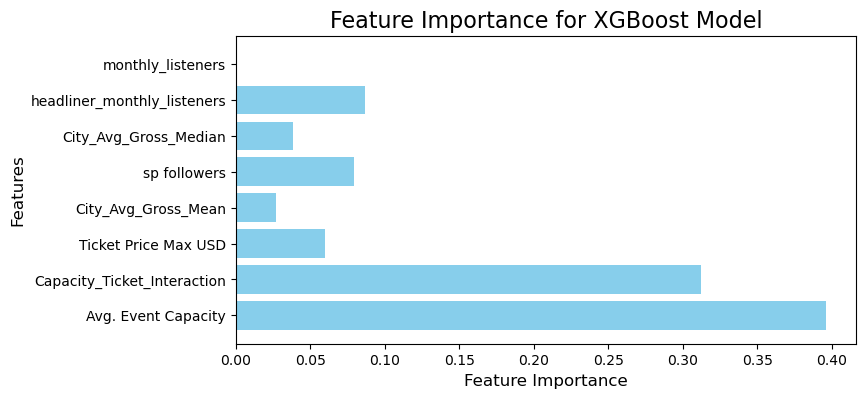

In [73]:
feature_importances = final_xgb_model.feature_importances_
plt.figure(figsize=(8, 4))
plt.barh(X_train.columns, feature_importances, color='skyblue')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance for XGBoost Model', fontsize=16)
plt.show()

### LightGBM

In [119]:
# Change ' ' from column names to '_' (LightGBM policy)
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [121]:
# Skewness on data
# Logarithmic transformation for target variable to mitigate the skew problem
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Removes an outlier from a target variable, Calculate the threshold for the 99th percentile
threshold = np.percentile(y_train, 99)

# Filter
X_train_filtered = X_train[y_train <= threshold]
y_train_filtered = y_train_log[y_train <= threshold]

In [199]:
# pre check before training
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train_filtered, y_train_filtered)

importance = pd.DataFrame({
    'Feature': X_train_filtered.columns,
    'Importance': lgbm_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1730
[LightGBM] [Info] Number of data points in the train set: 2661, number of used features: 7
[LightGBM] [Info] Start training from score 10.847479
                       Feature  Importance
4                 sp_followers         578
6  headliner_monthly_listeners         505
3          City_Avg_Gross_Mean         397
1  Capacity_Ticket_Interaction         394
0          Avg._Event_Capacity         380
5        City_Avg_Gross_Median         378
2         Ticket_Price_Max_USD         368


In [129]:
# Remove 'monthly_listeners' feature for now
X_train_filtered = X_train_filtered.drop(columns=['monthly_listeners'], errors='ignore')
X_test = X_test.drop(columns=['monthly_listeners'], errors='ignore')

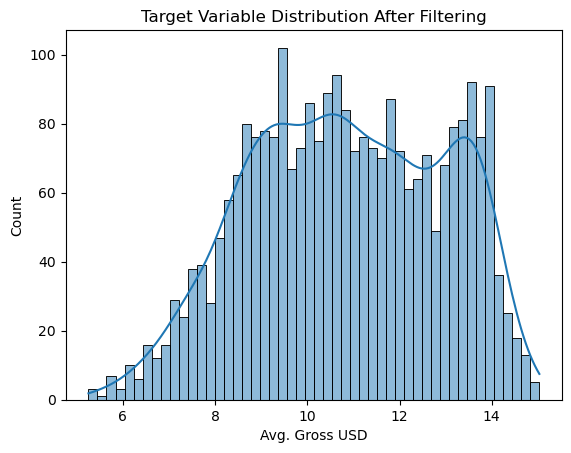

In [155]:
sns.histplot(y_train_filtered, kde=True, bins=50)
plt.title("Target Variable Distribution After Filtering")
plt.show()

In [157]:
for col in X_train_filtered.columns:
    print(f"{col}: min={X_train_filtered[col].min()}, max={X_train_filtered[col].max()}, unique={X_train_filtered[col].nunique()}")


Avg._Event_Capacity: min=75.0, max=29171.0, unique=1374
Capacity_Ticket_Interaction: min=1456.0, max=10172317.5, unique=1922
Ticket_Price_Max_USD: min=6.5, max=930.0, unique=386
City_Avg_Gross_Mean: min=535.3333333333334, max=2509119.9699999997, unique=350
sp_followers: min=1.0, max=54802787.0, unique=995
City_Avg_Gross_Median: min=500.0, max=2293046.0, unique=350
headliner_monthly_listeners: min=17.0, max=58016323.0, unique=2108
Capacity_Price_Interaction: min=71.42857142857143, max=29041.924778761062, unique=2087


In [193]:
# Scale the data

numerical_columns = X_train_filtered.select_dtypes(include=['float64', 'int64']).columns

# Initialize StandardScaler or MinMaxScaler
scaler = StandardScaler()  # or scaler = MinMaxScaler()

# Scale the numerical features of the training and test sets
X_train_filtered[numerical_columns] = scaler.fit_transform(X_train_filtered[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [224]:
# Noise addition: A small amount of random noise is added to a numerical feature to generate a new sample.

augmented_X_train = X_train_filtered.copy()
augmented_y_train = y_train_filtered.copy()

# Add Gaussian noise to each column
for col in augmented_X_train.columns:
    noise = np.random.normal(0, 0.01, augmented_X_train[col].shape)
    augmented_X_train[col] += noise

# Merge raw and enhanced data
X_train_augmented = pd.concat([X_train_filtered, augmented_X_train])
y_train_augmented = pd.concat([y_train_filtered, augmented_y_train])

In [240]:
# Check whether the indexes of X_train_augmented and y_train_augmented are unique
print("Is X_train_augmented index unique?", X_train_augmented.index.is_unique)
print("Is y_train_augmented index unique?", y_train_augmented.index.is_unique)

Is X_train_augmented index unique? True
Is y_train_augmented index unique? True


In [244]:
# index is not unique, reset the index
X_train_augmented = X_train_augmented.reset_index(drop=True)
y_train_augmented = y_train_augmented.reset_index(drop=True)

# make sure y_train_augmented is a DataFrame, name by 'Target'
if isinstance(y_train_augmented, pd.Series):
    y_train_augmented = y_train_augmented.rename('Target')
elif isinstance(y_train_augmented, pd.DataFrame):
    y_train_augmented.columns = ['Target']

# merge the data
correlation_data = pd.concat([X_train_augmented, y_train_augmented], axis=1)

print(correlation_data.head())

# correlation of the target variable
correlation = correlation_data.corr()
print('\n')
print(correlation['Target'].sort_values(ascending=False))

   Avg._Event_Capacity  Capacity_Ticket_Interaction  Ticket_Price_Max_USD  \
0             2.305365                     1.055257              0.408166   
1            -0.601564                    -0.486682             -0.645935   
2            -0.659776                    -0.460743              0.075292   
3            -0.585404                    -0.491191             -0.734702   
4             2.701831                     1.397116              0.519124   

   City_Avg_Gross_Mean  sp_followers  City_Avg_Gross_Median  \
0             1.338908      0.386966               1.809793   
1            -0.092031     -0.484647              -0.522622   
2            -0.912861     -0.424908              -0.459804   
3            -0.587855     -0.448463              -0.510440   
4             0.798272      0.329898               1.470700   

   headliner_monthly_listeners     Target  
0                     0.618670  12.391049  
1                    -0.594303   9.066585  
2                    -0.53

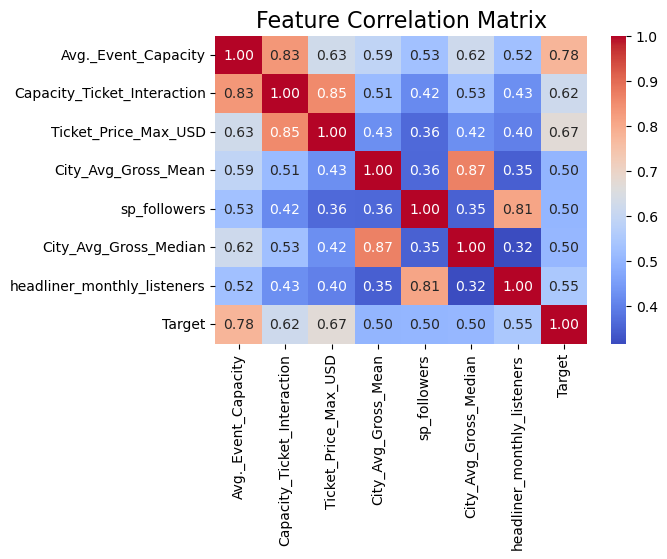

In [250]:
# Heatmap
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.show()

In [256]:
lgbm_model.fit(X_train_augmented, y_train_augmented)

importance = pd.DataFrame({
    'Feature': X_train_augmented.columns,
    'Importance': lgbm_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance)

[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 5322, number of used features: 7
[LightGBM] [Info] Start training from score 10.847479
                       Feature  Importance
3          City_Avg_Gross_Mean         494
4                 sp_followers         493
2         Ticket_Price_Max_USD         464
6  headliner_monthly_listeners         432
0          Avg._Event_Capacity         427
5        City_Avg_Gross_Median         385
1  Capacity_Ticket_Interaction         305


In [258]:
lgbm_model = LGBMRegressor(force_col_wise=True, random_state=42)

param_distributions = {
    'n_estimators': [50, 100, 200],
    # 'learning_rate': [0.01, 0.05, 0.1,],
    'max_depth': [-1, 5, 10],
    'num_leaves': [15, 31],
    'min_child_samples': [5, 10],
    'min_child_weight': [1e-5, 1e-3, 1e-2],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0],  # L1 regularization
    'reg_lambda': [1.0, 2.0, 5.0], # L2 regularization
    # 'max_bin': [256, 512]
}

# RandomizedSearchCV 
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=10,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

In [260]:
random_search.fit(X_train_augmented, y_train_augmented)

[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4790, number of used features: 7
[LightGBM] [Info] Start training from score 10.837902
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4790, number of used features: 7
[LightGBM] [Info] Start training from score 10.847453
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4790, number of used features: 7
[LightGBM] [Info] Start training from score 10.846621
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4790, number of used features: 7
[LightGBM] [Info] Start training from score 10.851182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

Exception ignored on calling ctypes callback function: <function _log_callback at 0x140334ea0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/lightgbm/basic.py", line 257, in _log_callback
Exception ignored on calling ctypes callback function: <function _log_callback at 0x12c934ea0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <function _log_callback at 0x11fe34ea0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 
Exception ignored on calling ctypes callback function: <function _log_callback at 0x11fc34ea0>
Traceback (mos

KeyboardInterrupt: 

In [ ]:
print("Random Search Best Parameters:", random_search.best_params_)

In [ ]:
# Visualize the result of the logarithm transformation of the target variable

plt.hist(y_train_log, bins=50)
plt.title("Log-Transformed Target Variable Distribution")
plt.show()

best_params = random_search.best_params_
final_lgbm_model = LGBMRegressor(**best_params, random_state=42)
final_lgbm_model.fit(X_train_filtered, y_train_filtered)

# Invert the predicted value
y_test_pred_log = final_lgbm_model.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("Test Set Results:")
print(f"  MAE: {test_mae:.2f}")
print(f"  RMSE: {test_rmse:.2f}")
print(f"  R^2: {test_r2:.2f}")

In [108]:
print(X_train.nunique())

Avg._Event_Capacity            1401
Capacity_Ticket_Interaction    1949
Ticket_Price_Max_USD            389
City_Avg_Gross_Mean             353
sp_followers                    997
City_Avg_Gross_Median           353
headliner_monthly_listeners    2129
monthly_listeners              2129
dtype: int64


In [77]:
# # actual value against the predicted value
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, alpha=0.6, label='Linear Regression', color='blue')
# plt.scatter(y_test, y_pred_rf, alpha=0.6, label='Random Forest', color='green')
# plt.scatter(y_test, y_pred_xgb, alpha=0.6, label='XGBoost', color='red')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black', label='Perfect Prediction')
# plt.xlabel('Actual Avg. Gross USD')
# plt.ylabel('Predicted Avg. Gross USD')
# plt.title('Actual vs Predicted Avg. Gross USD')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
list(df)